In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

In [ ]:
def dataset_split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

DATASET_SIZE = len(dataset[0])

In [ ]:
train_dataset, val_dataset, test_dataset = dataset_split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

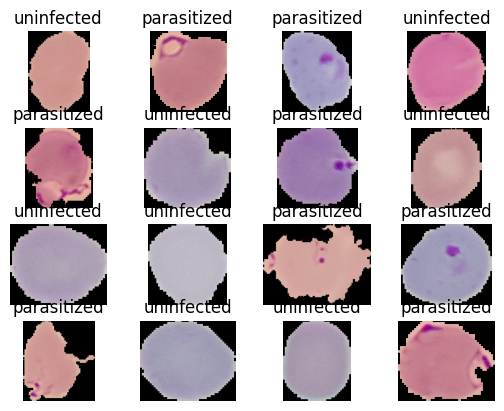

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].names

['parasitized', 'uninfected']

In [ ]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
                    loss = BinaryCrossentropy(),
                    metrics = 'accuracy')

In [ ]:
history = lenet_model.fit(train_dataset, validation_data = val_dataset, epochs = 20, verbose = True)

Epoch 1/20
689/689 [==============================] - 60s 71ms/step - loss: 0.3065 - accuracy: 0.8805 - val_loss: 0.3577 - val_accuracy: 0.8632
Epoch 2/20
689/689 [==============================] - 56s 81ms/step - loss: 0.1891 - accuracy: 0.9399 - val_loss: 0.1688 - val_accuracy: 0.9474
Epoch 3/20
689/689 [==============================] - 71s 103ms/step - loss: 0.1646 - accuracy: 0.9481 - val_loss: 0.2722 - val_accuracy: 0.9568
Epoch 4/20
689/689 [==============================] - 54s 78ms/step - loss: 0.1522 - accuracy: 0.9517 - val_loss: 1.3133 - val_accuracy: 0.8936
Epoch 5/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1375 - accuracy: 0.9549 - val_loss: 0.6679 - val_accuracy: 0.9456
Epoch 6/20
689/689 [==============================] - 51s 75ms/step - loss: 0.1226 - accuracy: 0.9616 - val_loss: 0.3420 - val_accuracy: 0.8733
Epoch 7/20
689/689 [==============================] - 51s 74ms/step - loss: 0.1123 - accuracy: 0.9663 - val_loss: 0.3052 - val_accuracy

In [ ]:
import matplotlib.pyplot as plt

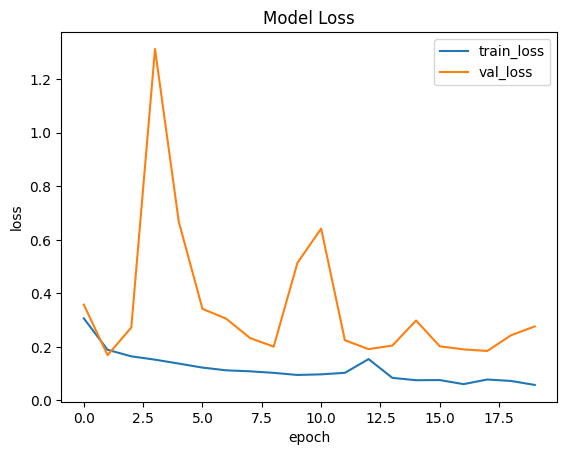

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 3ms/step - loss: 0.2547 - accuracy: 0.9354


[0.2547103762626648, 0.9354370832443237]

In [ ]:
def classify(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 17ms/step


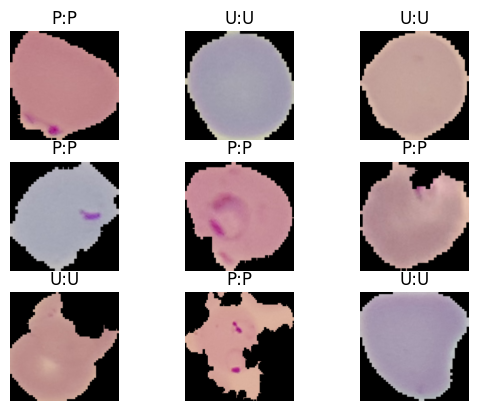

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(classify(label.numpy()[0])) + ":" + str(classify(lenet_model.predict(image)[0][0])))
  plt.axis('off')